# Find good estimates for noise scales

One of the ongoing difficulties with confronting a model with data, is
the scaling of noise coefficients: if they are too large, the model
or data are meaningless, but if they are too small, the model can't
predict the data (and inference is not possible).

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


## From the raw data

Let's start with raw sEEG data, for completeness:

We load the raw data here, plot it w/ histogram & spectrum.

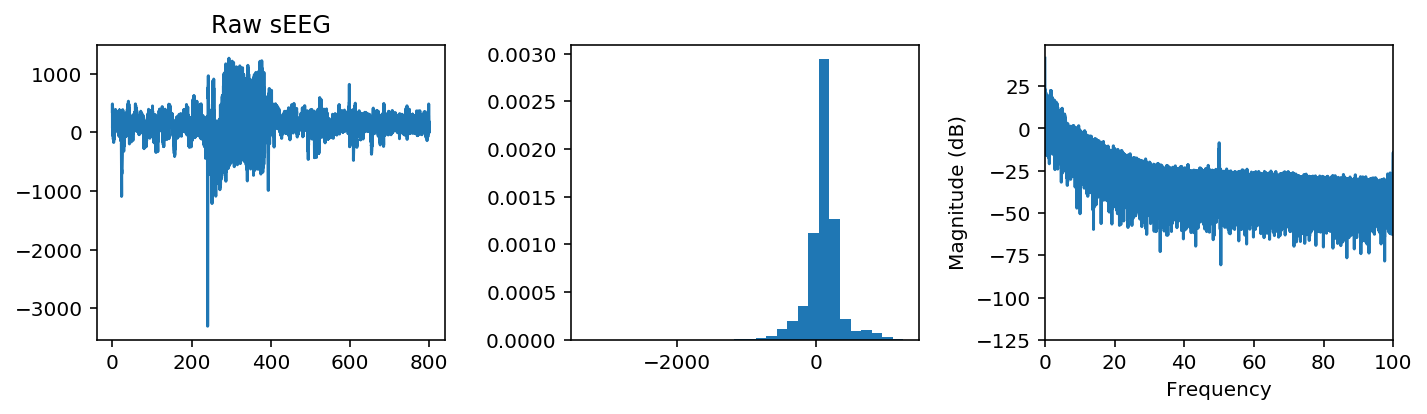

In [2]:
close('all')
npy = np.load('data/complex.npy')
k = 500
nchan, nsamp = npy.shape
t = np.r_[:nsamp] / 512.0
npy = npy[:, t<800]
t = t[t<800]
T = t[:t.size//k*k].reshape((-1, k)).mean(axis=1)
fig, ax = subplots(nrows=1, ncols=3, figsize=(10, 3))
ax[0].plot(t, npy[0]), ax[0].set_title('Raw sEEG')
ax[1].hist(npy[0], 30, normed=1)
ax[2].magnitude_spectrum(npy[0], Fs=512, scale='dB')
ax[2].set_xlim([0, 100]);
tight_layout()

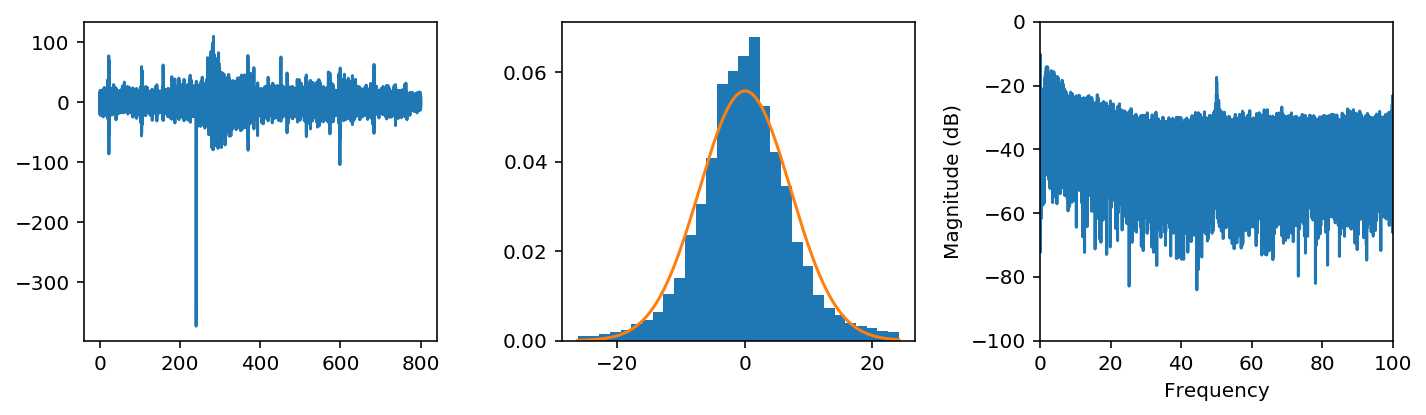

In [3]:
# whiten, roughly normal
fig, ax = subplots(nrows=1, ncols=3, figsize=(10, 3))
c = diff(npy[0]);
c1,c99 = percentile(c, [1, 99])
c_ = c[(c>c1)*(c<c99)]
ax[0].plot(t[:-1], c), ylim([c1,c99])
ax[1].hist(c_, 30, normed=1)
x=r_[c1:c99:500j];
ax[1].plot(x, stats.norm.pdf(x, *stats.norm.fit(c_)));
ax[2].magnitude_spectrum(c_, Fs=512, scale='dB')
ax[2].set_xlim([0, 100]); ax[2].set_ylim([-100, 0])
tight_layout()

As a simple temporal smoothing, we square the above & average windows,

/Users/maedoc/miniconda3/envs/scipy/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


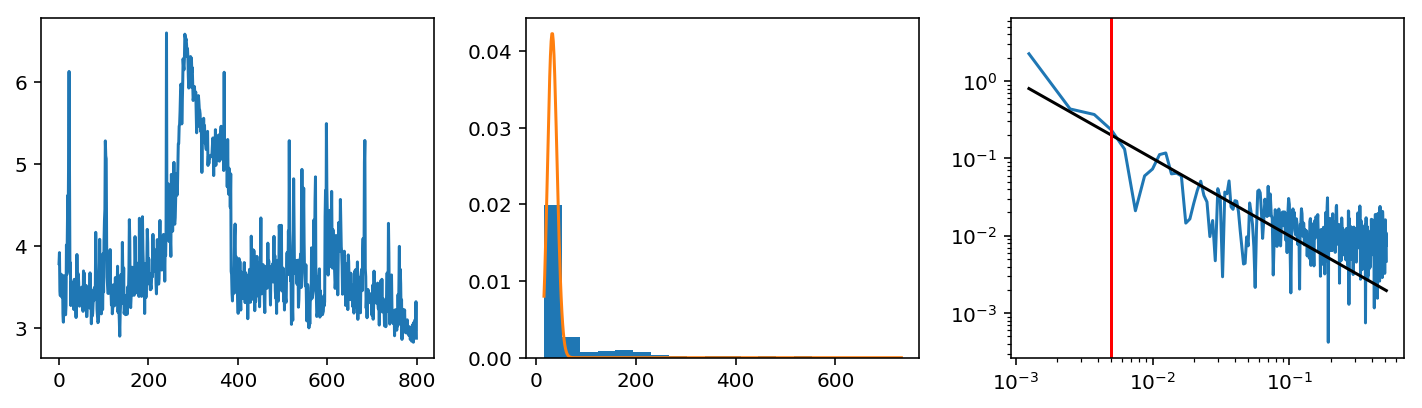

In [4]:
fig, ax = subplots(nrows=1, ncols=3, figsize=(10, 3))
c2 = (c**2)[:c.size//k*k].reshape((-1, k)).mean(axis=1);
ax[1].hist(c2, 20, normed=1); x=r_[c2.min():c2.max():500j]
ax[1].plot(x, stats.chi2.pdf(x, *stats.chi2.fit(c2[c2<percentile(c2,75)], fdf=k)))
ax[0].plot(T[:len(c2)], log(c2+1))
s, f, l = ax[2].magnitude_spectrum(log(c2+1), Fs=512.0/k, scale='dB')
cla()
ax[2].loglog(f, s)
ax[2].loglog(f, 1e-3/f, 'k')
ax[2].axvline(1.0/200, color='r')
tight_layout()

- _Left_ Time-series considered as feature
- _Middle_ Histogram of _Left_ with $\chi_2$ fit
- _Right_ Spectrum of _Left_ with linear approximation in black & seizure cycle frequency marked in <span style="color:red">red</span>.

__TODO__ We should be able to extract useful bounds on observation noise for `eps` from
the upper part of the spectrum.

In [5]:
c3 = log(c2+1)
c3f = fft.fft(c3)
c3ff = fft.fftfreq(len(c3), d=T[1] - T[0])

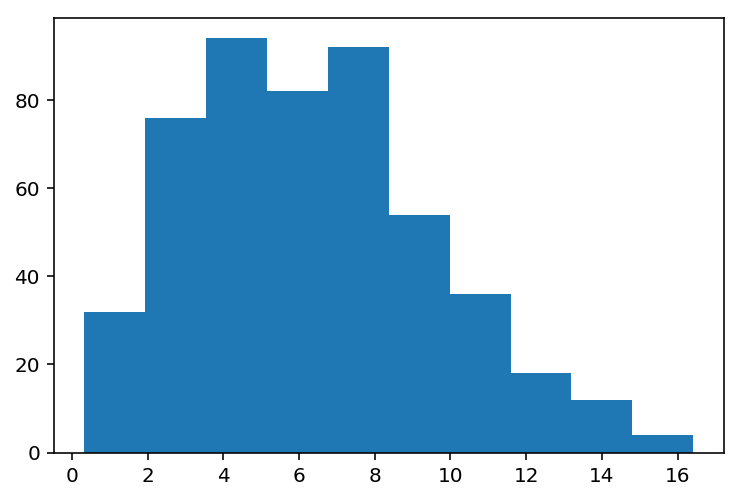

In [6]:
hist(abs(c3f)[abs(c3ff)>0.2]);

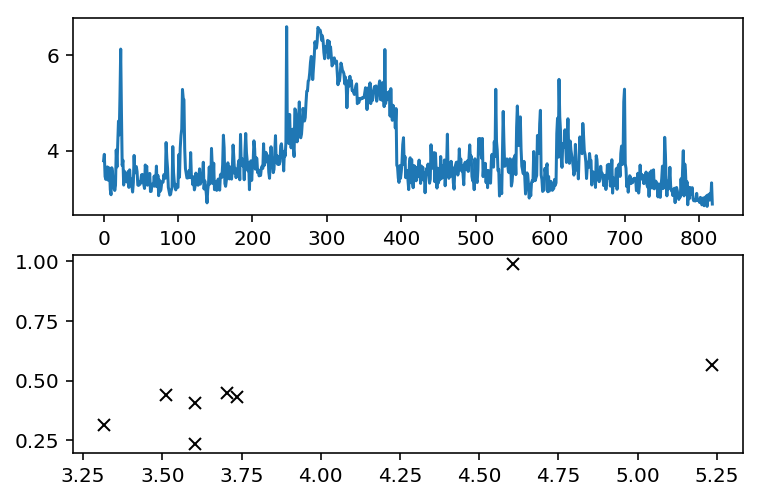

In [7]:
c4 = c3[:800].reshape((-1, 100))
subplot(211), plot(c3)
subplot(212)
plot(c4.mean(axis=1), c4.std(axis=1), 'kx')